# Photo Classifier: Model training

## Imports and configuration

In [1]:
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline
%load_ext autoreload
%autoreload 2
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import matplotlib.pyplot as plt
from torchsummary import summary
import logging
import random
import numpy as np
from ipywidgets import interact
import ipywidgets as widgets
from scipy.signal import savgol_filter

In [3]:
from constants import *
from utils import get_indices, round_up_to_odd
from image_transforms import IMAGE_TRANSFORMS
from plotting import imshow_tensor, show_image
from data_loaders.image_loader_labels_from_folders import ImageLoader
from image_data import ImageData
from model import get_pretrained_model_for_transfer_learning
from file_io import save_pickle_file
from learners.utils import get_learner
from hyperparamer_tuning import test_hyperparameters

In [4]:
random.seed(42)
logging.basicConfig(level=logging.INFO)

## Data loading and grouping to training, validation and test set

In [5]:
data_loader = ImageLoader()
data = data_loader.load_images_with_labels(SOURCE_DATA_PATH)

INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 1/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 2/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 3/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 4/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 5/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 6/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 7/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 8/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 9/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 10/136 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Black bears: 11/136 images load

INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 42/133 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 43/133 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 44/133 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 45/133 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 46/133 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 47/133 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 48/133 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 49/133 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 50/133 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 51/133 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Gr

INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 129/133 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 130/133 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 131/133 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 132/133 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Grizzly bears: 133/133 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 1/110 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 2/110 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 3/110 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 4/110 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 5/110 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 6/110

INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 86/110 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 87/110 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 88/110 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 89/110 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 90/110 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 91/110 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 92/110 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 93/110 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 94/110 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 95/110 images loaded
INFO:data_loaders.image_loader_labels_from_folders:Folder Teddybears: 96/110 images loaded

In [6]:
indices = list(range(len(data)))
train_idx, valid_idx, test_idx = get_indices(indices, P_TRAINING, P_VALID, P_TEST)
image_data = ImageData(data, train_idx, valid_idx, test_idx)

## Image preprocessing

In [7]:
@interact(index=widgets.IntSlider(min=0, max=10, step=1, value=0, continuous_update=False))
def show(index=0, data_set_name=['training', 'validation', 'test']):
    label = image_data.get_label(index, data_set_name)
    image = image_data.get_image(index, data_set_name)
    show_image(image, label)

interactive(children=(IntSlider(value=0, continuous_update=False, description='index', max=10), Dropdown(descr…

In [8]:
test_image = image_data.get_image(0, 'training')
training_transforms = IMAGE_TRANSFORMS['training']

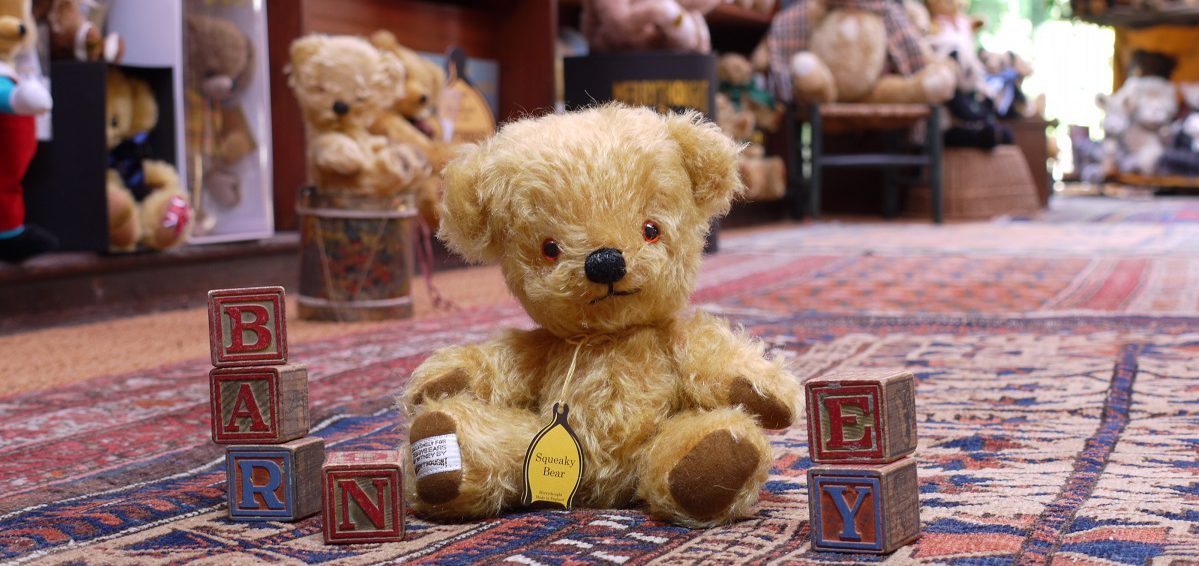

In [9]:
test_image

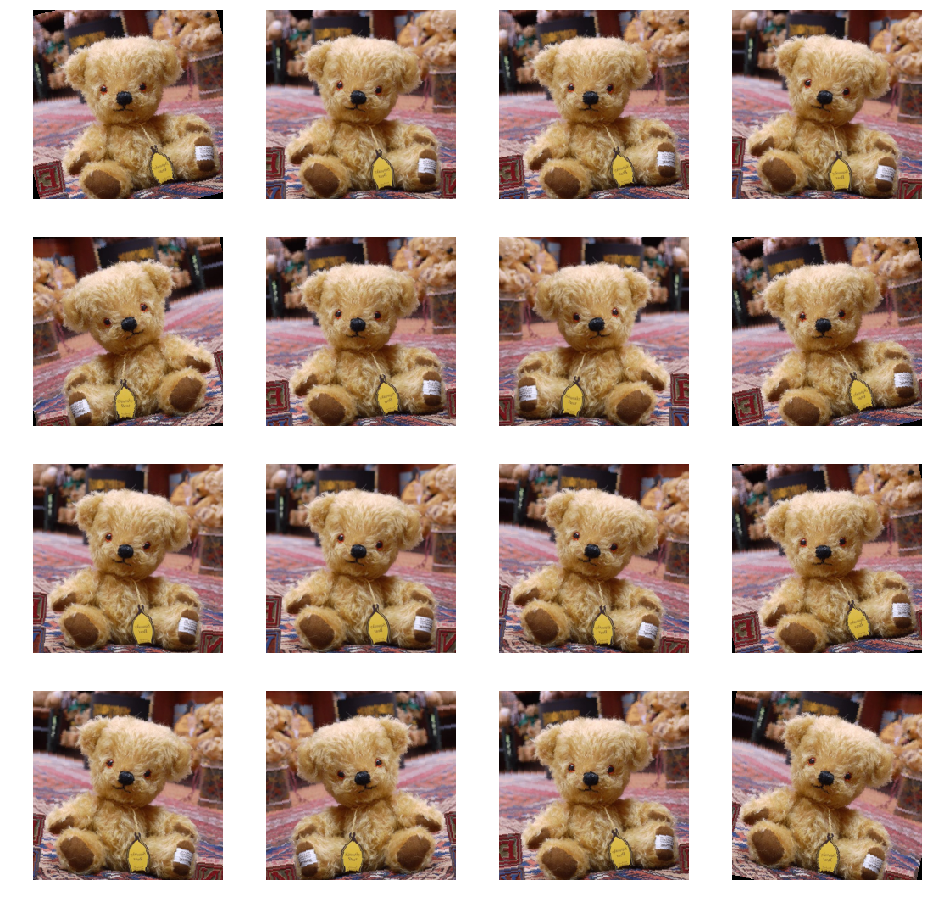

In [10]:
_ = plt.figure(figsize=(16,16))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    transformed_image = training_transforms(test_image)
    _ = imshow_tensor(transformed_image, ax=ax, mean=IMAGE_NET_MEAN, std=IMAGE_NET_STD)

## Model

In [11]:
n_classes = len(image_data.labels)
model = get_pretrained_model_for_transfer_learning(n_classes, IS_MULTILABEL_CLASSIFICATION, DROPOUT, MODEL_ARCHITECTURE)

In [12]:
summary(model, input_size=(3, 224, 224), batch_size=BATCH_SIZE, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [6, 64, 224, 224]           1,792
              ReLU-2          [6, 64, 224, 224]               0
            Conv2d-3          [6, 64, 224, 224]          36,928
              ReLU-4          [6, 64, 224, 224]               0
         MaxPool2d-5          [6, 64, 112, 112]               0
            Conv2d-6         [6, 128, 112, 112]          73,856
              ReLU-7         [6, 128, 112, 112]               0
            Conv2d-8         [6, 128, 112, 112]         147,584
              ReLU-9         [6, 128, 112, 112]               0
        MaxPool2d-10           [6, 128, 56, 56]               0
           Conv2d-11           [6, 256, 56, 56]         295,168
             ReLU-12           [6, 256, 56, 56]               0
           Conv2d-13           [6, 256, 56, 56]         590,080
             ReLU-14           [6, 256,

## Model training

In [13]:
Learner = get_learner(IS_MULTILABEL_CLASSIFICATION)
learner = Learner(model, use_gpu=USE_GPU)
losses, losses_valid = learner.fit_model(image_data,
                                        image_transforms_training=IMAGE_TRANSFORMS['training'],
                                        image_transforms_validation=IMAGE_TRANSFORMS['validation'],
                                        batch_size=BATCH_SIZE,
                                        epochs=EPOCHS,
                                        learning_rate=LEARNING_RATE,
                                        weight_decay=WEIGHT_DECAY,
                                        early_stop_option=USE_EARLY_STOP)

INFO:learners.base_learner:
            Epoch: 1/15
            Validation loss: 0.3231261372566223
INFO:learners.base_learner:
            Epoch: 2/15
            Validation loss: 0.255951851606369
INFO:learners.base_learner:
            Epoch: 3/15
            Validation loss: 0.1628466099500656
INFO:learners.base_learner:
            Epoch: 4/15
            Validation loss: 0.1343797892332077
INFO:learners.base_learner:
            Epoch: 5/15
            Validation loss: 0.15199147164821625
INFO:learners.base_learner:
            Epoch: 6/15
            Validation loss: 0.1694173365831375
INFO:learners.base_learner:Early stop criterion filled; fitting completed!
INFO:learners.base_learner:Lowest validation loss: epoch: 4; loss: 0.1343797892332077


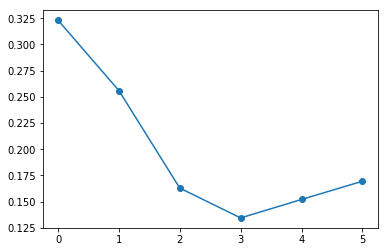

In [14]:
_ = plt.plot(losses_valid, '-o')

In [15]:
window_size = round_up_to_odd(len(losses)/4)
smoothed_losses = savgol_filter(losses, window_size, 2)

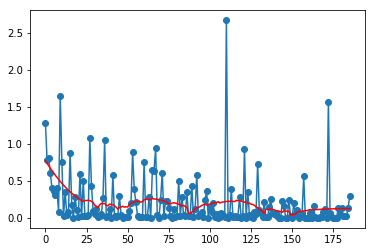

In [16]:
_ = plt.plot(losses, '-o')
_ = plt.plot(smoothed_losses, 'r-')

## Save data and model

In [17]:
save_pickle_file(learner, MODEL_FILE_PATH)
save_pickle_file(image_data, IMAGE_DATA_PATH)

## Hyperparameter tuning

In [18]:
grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'weight_decay': [0, 0.01, 0.1],
    'epochs': [5],
    'batch_size': [5, 10],
    'image_transforms_training': [IMAGE_TRANSFORMS['training']],
    'image_transforms_validation': [IMAGE_TRANSFORMS['validation']]
}

In [19]:
results = test_hyperparameters(learner, image_data, grid)

INFO:hyperparamer_optimization:1/18
INFO:learners.base_learner:
            Epoch: 1/5
            Validation loss: 0.7340565323829651
INFO:learners.base_learner:
            Epoch: 2/5
            Validation loss: 0.30891352891921997
INFO:learners.base_learner:
            Epoch: 3/5
            Validation loss: 0.33809107542037964
INFO:learners.base_learner:
            Epoch: 4/5
            Validation loss: 0.3881223201751709
INFO:learners.base_learner:Early stop criterion filled; fitting completed!
INFO:learners.base_learner:Lowest validation loss: epoch: 2; loss: 0.30891352891921997
INFO:hyperparamer_optimization:2/18
INFO:learners.base_learner:
            Epoch: 1/5
            Validation loss: 0.4090407192707062
INFO:learners.base_learner:
            Epoch: 2/5
            Validation loss: 0.5310607552528381
INFO:learners.base_learner:
            Epoch: 3/5
            Validation loss: 0.41045132279396057
INFO:learners.base_learner:Early stop criterion filled; fitting comple

INFO:learners.base_learner:
            Epoch: 4/5
            Validation loss: 124.03348541259766
INFO:learners.base_learner:Early stop criterion filled; fitting completed!
INFO:learners.base_learner:Lowest validation loss: epoch: 3; loss: 60.24201583862305
INFO:hyperparamer_optimization:16/18
INFO:learners.base_learner:
            Epoch: 1/5
            Validation loss: 149.6856689453125
INFO:learners.base_learner:
            Epoch: 2/5
            Validation loss: 73.6379623413086
INFO:learners.base_learner:
            Epoch: 3/5
            Validation loss: 73.20005798339844
INFO:learners.base_learner:
            Epoch: 4/5
            Validation loss: 27.062604904174805
INFO:learners.base_learner:
            Epoch: 5/5
            Validation loss: 40.06920623779297
INFO:learners.base_learner:Lowest validation loss: epoch: 4; loss: 27.062604904174805
INFO:hyperparamer_optimization:17/18
INFO:learners.base_learner:
            Epoch: 1/5
            Validation loss: 126.6127014

In [20]:
results

learning_rate  weight_decay  epochs  batch_size  \
0           0.001          0.00       5           5   
1           0.001          0.00       5          10   
2           0.001          0.01       5           5   
3           0.001          0.01       5          10   
4           0.001          0.10       5           5   
5           0.001          0.10       5          10   
6           0.010          0.00       5           5   
7           0.010          0.00       5          10   
8           0.010          0.01       5           5   
9           0.010          0.01       5          10   
10          0.010          0.10       5           5   
11          0.010          0.10       5          10   
12          0.100          0.00       5           5   
13          0.100          0.00       5          10   
14          0.100          0.01       5           5   
15          0.100          0.01       5          10   
16          0.100          0.10       5           5   
17          0.100          0.10       5          10   

                            image_transforms_training  \
0   Compose(\n    RandomResizedCrop(size=(256, 256...   
1   Compose(\n    RandomResizedCrop(size=(256, 256...   
2   Compose(\n    RandomResizedCrop(size=(256, 256...   
3   Compose(\n    RandomResizedCrop(size=(256, 256...   
4   Compose(\n    RandomResizedCrop(size=(256, 256...   
5   Compose(\n    RandomResizedCrop(size=(256, 256...   
6   Compose(\n    RandomResizedCrop(size=(256, 256...   
7   Compose(\n    RandomResizedCrop(size=(256, 256...   
8   Compose(\n    RandomResizedCrop(size=(256, 256...   
9   Compose(\n    RandomResizedCrop(size=(256, 256...   
10  Compose(\n    RandomResizedCrop(size=(256, 256...   
11  Compose(\n    RandomResizedCrop(size=(256, 256...   
12  Compose(\n    RandomResizedCrop(size=(256, 256...   
13  Compose(\n    RandomResizedCrop(size=(256, 256...   
14  Compose(\n    RandomResizedCrop(size=(256, 256...   
15  Compose(\n    RandomResizedCrop(size=(256, 256...   
16  Compose(\n    RandomResizedCrop(size=(256, 256...   
17  Compose(\n    RandomResizedCrop(size=(256, 256...   

                          image_transforms_validation  lowest_validation_loss  \
0   Compose(\n    Resize(size=256, interpolation=P...                0.308914   
1   Compose(\n    Resize(size=256, interpolation=P...                0.409041   
2   Compose(\n    Resize(size=256, interpolation=P...                0.216714   
3   Compose(\n    Resize(size=256, interpolation=P...                0.178948   
4   Compose(\n    Resize(size=256, interpolation=P...                0.183400   
5   Compose(\n    Resize(size=256, interpolation=P...                0.151182   
6   Compose(\n    Resize(size=256, interpolation=P...                0.909070   
7   Compose(\n    Resize(size=256, interpolation=P...                1.039490   
8   Compose(\n    Resize(size=256, interpolation=P...                2.043033   
9   Compose(\n    Resize(size=256, interpolation=P...                0.820108   
10  Compose(\n    Resize(size=256, interpolation=P...                0.206379   
11  Compose(\n    Resize(size=256, interpolation=P...                0.388688   
12  Compose(\n    Resize(size=256, interpolation=P...                0.920740   
13  Compose(\n    Resize(size=256, interpolation=P...                5.040662   
14  Compose(\n    Resize(size=256, interpolation=P...               60.242016   
15  Compose(\n    Resize(size=256, interpolation=P...               27.062605   
16  Compose(\n    Resize(size=256, interpolation=P...               49.579376   
17  Compose(\n    Resize(size=256, interpolation=P...               11.056993   

         time  
0   48.387461  
1   33.776790  
2   49.113183  
3   56.435625  
4   70.146346  
5   40.204504  
6   71.473740  
7   40.212545  
8   42.033009  
9   64.277612  
10  42.261903  
11  39.550839  
12  69.779458  
13  39.814276  
14  55.764220  
15  64.731378  
16  69.421689  
17  64.451039